# Assignment 12
Our goal is to see if we can use an autoencoder to remove noise.
1. Copy the add_noise.ipynb code and the network part of the ae_emnist_simple.ipynb (the fully connected not the CNN) code to this workbook.
2. Train the autoencoder just as in class, and after training, send the **noisy** test digits through the autoencoder.  Does the autoencoder reconstruct them properly?  (**NOTE**: you could just load the pretrained model that we previously saved, rather than defining/compiling/fitting the model all over from scratch.)
    * Look at the **mse** for the **noisy** decoded images relative to the non-noisy version of the nopisy images you sent through the network.  Meaning: send the x_test_noisy images through the network and get the decoded images from these.  Then when making the mse, use the decoded images and the **non-noisy** version of the images to compare.   Remember that the goal of denoising is to remove the noise - so the decoded image should look like the non-noisy version of the original image!
    * Do the "eye-test" for 10 samples from the noisy dataset.
3. Now do the following: modify the **fit** part of the autoencoder:
    * Use the **noisy** training data x_train_noisy as your **input**
    * Use the **original** training data x_train as your **target**
    
    Train this new autoencoder.   Again, after training, send the **noisy** test digits through the autoencoder.  Does the autoencoder reconstruct them properly?
    * Again look at the **mse** for the **noisy** decoded images relative to the non-noisy version of the nopisy images you sent through the network.  Is this better than step 2?  It should be!
    * Do the "eye-test" for 10 samples from the noisy dataset.
    
**Extra**: Create another **stacked** autoencoder/classifier.   In this case, train on the letters dataset, but apply it to the digits just as in cnn_stacked_ae.   You will simply need to copy and modify the ae_cnn_emnist.py file so that it uses the letters (df_test['label']>9).  Save the new models with an "_letter" tag so that you don't overwrite the models trained using the digits.

# Add Noise

In [6]:
import numpy as np
import scipy.io as sio
#
# See this for more info: https://arxiv.org/pdf/1702.05373.pdf
mat = sio.loadmat('/fs/scratch/PAS1585/emnist/matlab/emnist-byclass.mat')
#print(mat)

data = mat['dataset']

ex_train = data['train'][0,0]['images'][0,0]
ey_train = data['train'][0,0]['labels'][0,0]
ex_test = data['test'][0,0]['images'][0,0]
ey_test = data['test'][0,0]['labels'][0,0]

ex_train = ex_train.reshape( (ex_train.shape[0], 28,28), order='F')
ex_test = ex_test.reshape( (ex_test.shape[0], 28,28), order='F')

ex_train = ex_train.reshape( (ex_train.shape[0], 784))
ex_test = ex_test.reshape( (ex_test.shape[0], 784))
ex_train = ex_train.astype('float32') / 255.
ex_test = ex_test.astype('float32') / 255.

import pandas as pd

df_train = pd.DataFrame(ex_train)
df_train['label'] = ey_train

df_test = pd.DataFrame(ex_test)
df_test['label'] = ey_test

#
# Make digits
df_digits_train = df_train[df_train['label']<=9]
x_train = df_digits_train.iloc[:,:784].values
y_train = df_digits_train['label'].values

df_digits_test = df_test[df_test['label']<=9]
x_test = df_digits_test.iloc[:,:784].values
y_test = df_digits_test['label'].values


In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 


# Train

In [20]:
from keras import models
from keras import layers
from keras import regularizers

# this is the size of our encoded representations
encoding_dim = 128  
#
# Define out model
network = models.Sequential()
#
# This is the "encoder"
network.add(layers.Dense(encoding_dim,activation='relu',input_shape=(28*28,)))
#
# This is the decoder
network.add(layers.Dense(28*28,activation='sigmoid'))
#
# Now compile the network!
network.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['mse'])
print("network: ",network.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
network:  None


In [21]:
history = network.fit(x_train, x_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 345035 samples, validate on 57918 samples
Epoch 1/25
345035/345035 [==============================] - 13s 38us/step - loss: 0.2772 - mean_squared_error: 0.0550 - val_loss: 0.2119 - val_mean_squared_error: 0.0321
Epoch 2/25
345035/345035 [==============================] - 13s 37us/step - loss: 0.1911 - mean_squared_error: 0.0254 - val_loss: 0.1762 - val_mean_squared_error: 0.0207
Epoch 3/25
345035/345035 [==============================] - 13s 37us/step - loss: 0.1666 - mean_squared_error: 0.0177 - val_loss: 0.1587 - val_mean_squared_error: 0.0152
Epoch 4/25
345035/345035 [==============================] - 13s 37us/step - loss: 0.1526 - mean_squared_error: 0.0134 - val_loss: 0.1477 - val_mean_squared_error: 0.0119
Epoch 5/25
345035/345035 [==============================] - 13s 37us/step - loss: 0.1437 - mean_squared_error: 0.0108 - val_loss: 0.1406 - val_mean_squared_error: 0.0098
Epoch 6/25
345035/345035 [==============================] - 13s 37us/step - loss: 0.1379 - mean_squ

In [22]:
network.save('ae_assignment12_1.h5')

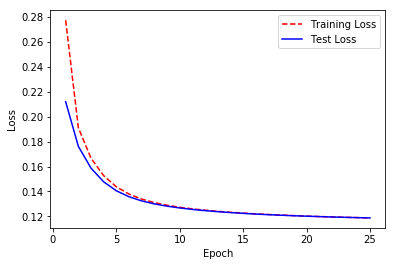

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

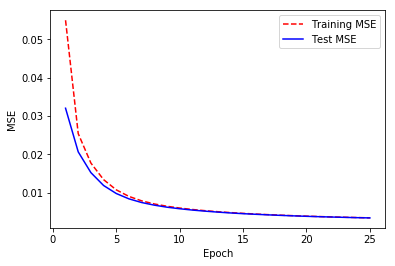

In [25]:
# Get training and test loss histories
training_loss = history.history['mean_squared_error']
test_loss = history.history['val_mean_squared_error']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training MSE', 'Test MSE'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show();

In [26]:
decoded_imgs = network.predict(x_test_noisy)
print("decoded_imgs.shape",decoded_imgs.shape)

decoded_imgs.shape (57918, 784)


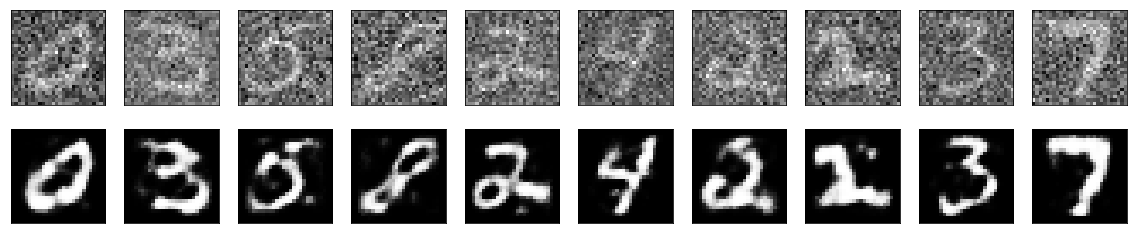

In [49]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    #diplay noisy
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

They are reconstructed without noise (most of it)!

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


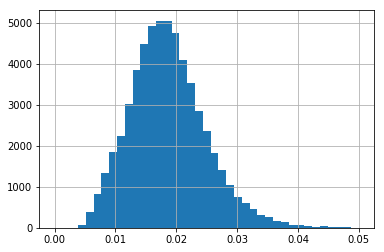

In [50]:
import numpy as np
import pandas as pd
#
# Now get the MSE for the decoded images
# we did this above, but since it is fast we do it again for clarity
mse = np.mean(np.power(x_test-decoded_imgs, 2), axis=1)
df_digits_test['mse'] = mse

hist = df_digits_test['mse'].hist(bins=np.linspace(0.0,0.05,40))

In [51]:
history = network.fit(x_train_noisy, x_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 345035 samples, validate on 57918 samples
Epoch 1/25
345035/345035 [==============================] - 13s 39us/step - loss: 0.1648 - mean_squared_error: 0.0167 - val_loss: 0.1210 - val_mean_squared_error: 0.0041
Epoch 2/25
345035/345035 [==============================] - 13s 39us/step - loss: 0.1583 - mean_squared_error: 0.0153 - val_loss: 0.1225 - val_mean_squared_error: 0.0044
Epoch 3/25
345035/345035 [==============================] - 13s 39us/step - loss: 0.1556 - mean_squared_error: 0.0147 - val_loss: 0.1236 - val_mean_squared_error: 0.0046
Epoch 4/25
345035/345035 [==============================] - 13s 39us/step - loss: 0.1542 - mean_squared_error: 0.0143 - val_loss: 0.1243 - val_mean_squared_error: 0.0047
Epoch 5/25
345035/345035 [==============================] - 13s 39us/step - loss: 0.1534 - mean_squared_error: 0.0141 - val_loss: 0.1248 - val_mean_squared_error: 0.0048
Epoch 6/25
345035/345035 [==============================] - 13s 39us/step - loss: 0.1529 - mean_squ

In [52]:
network.save('ae_assignment12_2.h5')

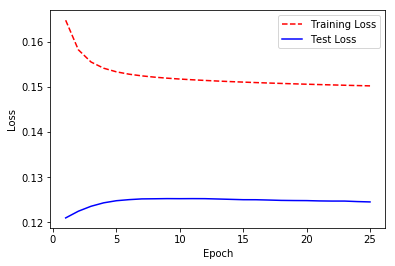

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

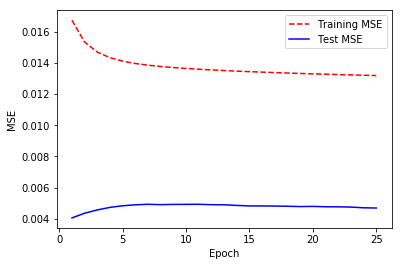

In [54]:
# Get training and test loss histories
training_loss = history.history['mean_squared_error']
test_loss = history.history['val_mean_squared_error']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training MSE', 'Test MSE'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show();

In [55]:
decoded_imgs = network.predict(x_test_noisy)
print("decoded_imgs.shape",decoded_imgs.shape)

decoded_imgs.shape (57918, 784)


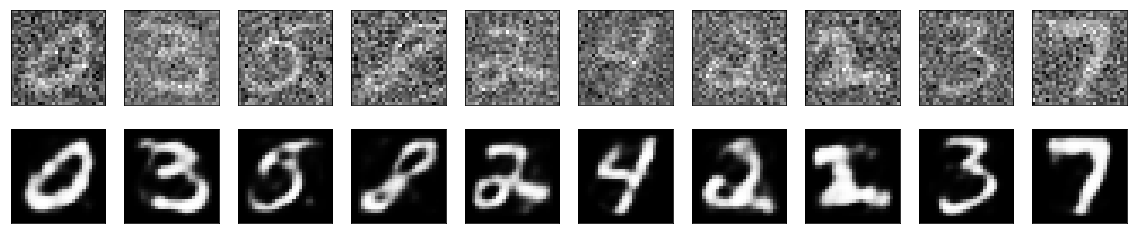

In [56]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    #diplay noisy
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


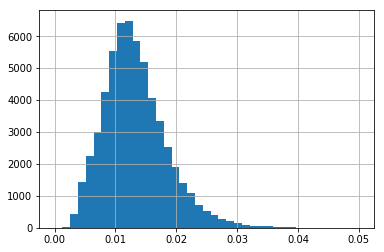

In [57]:
import numpy as np
import pandas as pd
#
# Now get the MSE for the decoded images
# we did this above, but since it is fast we do it again for clarity
mse = np.mean(np.power(x_test-decoded_imgs, 2), axis=1)
df_digits_test['mse'] = mse

hist = df_digits_test['mse'].hist(bins=np.linspace(0.0,0.05,40))

This is clearly better, we can see it by eye (less noise present in the decoded images) and in the mse (the tail dies out at around 0,03 mse instead of 0.04 as before.